# BLSTM with BLitz Framework

Bayes by Backprop

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [26]:
df = pd.read_csv("max_mag_by_month.csv")
df.rename({"time": "Date"}, axis=1, inplace=True)
df.head()

,Date,A,B,C,D,E,F,G
0,1960-01-01,0.0,0.0,0.0,6.3,0.0,0.0,0.0
1,1960-02-01,0.0,0.0,0.0,0.0,0.0,6.1,0.0
2,1960-03-01,0.0,0.0,0.0,0.0,0.0,8.0,0.0
3,1960-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1960-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
magC = df["C"]
scaler = StandardScaler()

magC_arr = np.array(magC).reshape(-1, 1)
magC = scaler.fit_transform(magC_arr)

magC_unscaled = df["C"]

In [16]:
window_size = 120 # 10 ans

In [17]:
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [18]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [20]:
Xs, ys = create_timestamps_ds(magC)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

C:\Users\asus\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


In [21]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.0462
Iteration: 500 Val-loss: 0.0458


In [22]:
#pred_unscaled
original = magC_unscaled[1:][window_size:]

In [27]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [28]:
def pred_stock_future(X_test, future_length, sample_nbr=10):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [29]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [30]:
future_length = 12  # 1 year
sample_nbr = 4
ci_multiplier = 5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [102]:
y = np.array(df.C[-156:]).reshape(-1, 1)  # test set length
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{:.4f} our predictions are in our confidence interval".format(np.mean(total)))

0.6218 our predictions are in our confidence interval


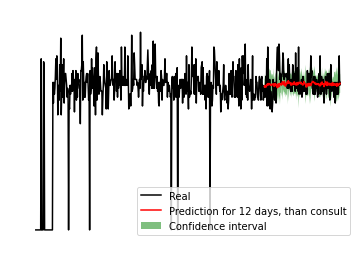

In [39]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

plt.title("EQ magnitude", color="white")

plt.plot(df_pred.index,
         df_pred.C,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

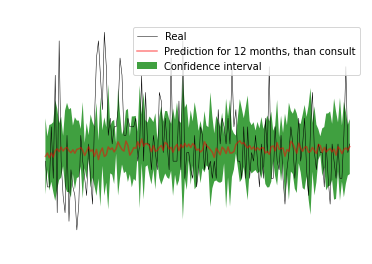

In [40]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("EQ Magnitude Prediction", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.C[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()

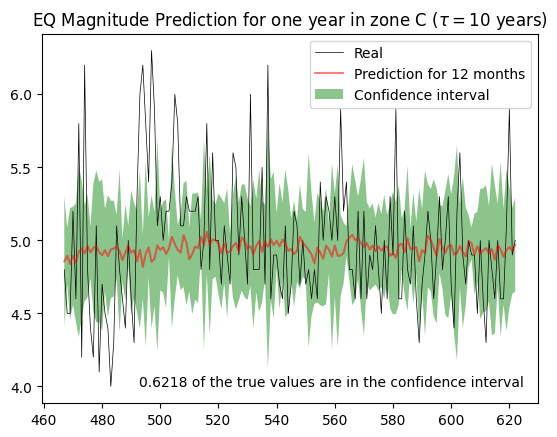

In [110]:
plt.rcParams.update(plt.rcParamsDefault)

plt.title(r"EQ Magnitude Prediction for one year in zone C ($\tau = 10$ years)")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.45)

plt.plot(idx_pred,
         df_pred.C[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red",
         alpha=0.5)
plt.text(625, 4, f'{np.mean(total):.4f} of the true values are in the confidence interval', horizontalalignment='right')

plt.legend()

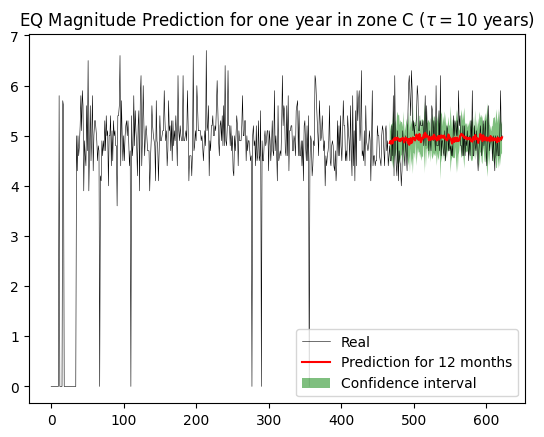

In [56]:
plt.title(r"EQ Magnitude Prediction for one year in zone C ($\tau = 10$ years)")

plt.plot(df_pred.index,
         df_pred.C,
         color='black',
         label="Real",
         linewidth=.4)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

Let's try to implement a calibration curve, which will assess the model calibration (cf. hands-on BNN)

In [62]:
df_pred.C[-156:]

467    4.8
468    4.5
469    4.5
470    5.2
471    4.6
      ... 
618    4.6
619    5.1
620    5.9
621    4.9
622    5.0
Name: C, Length: 156, dtype: float64

In [65]:
scaler.inverse_transform(preds_test[0]).mean() # preds_test contient les predictions sur le test set

4.8558209919638715

In [66]:
pred_mean_unscaled[0]

array([4.855821], dtype=float32)

In [61]:
len(preds_test)

156

In [90]:
pred_mean_estimator = np.array([pred_mean_unscaled[i]/i for i in range(1, len(pred_mean_unscaled))])
observed_prob_estimator = np.array([df_pred.C[i + 466 ]/i for i in range(1, len(pred_mean_unscaled))])

In [98]:
calibration_curve = pred_mean_estimator.reshape(155,) / observed_prob_estimator.reshape(155,)
x = np.linspace(0, 1, 155)

Let's try again with a window size of 25 years and a prediction of 5 years in zone C and 10 simulations per prediciton.

In [101]:
window_size = 12 * 25  # 25 years

In [135]:
Xs, ys = create_timestamps_ds(magC)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [136]:
iteration = 0
for epoch in range(10):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%250==0:
            preds_test = net(X_test)[:,0].unsqueeze(1)
            loss_test = criterion(preds_test, y_test)
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

Iteration: 250 Val-loss: 0.0647
Iteration: 500 Val-loss: 0.0503


In [137]:
#pred_unscaled
original = magC_unscaled[1:][window_size:]

In [138]:
df_pred = pd.DataFrame(original)
df_pred["Date"] = df.Date
df["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [140]:
future_length = 12 * 5  # 5 years
sample_nbr = 10
ci_multiplier = 5
idx_pred, preds_test = pred_stock_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [141]:
y = np.array(df.C[-156:]).reshape(-1, 1)  # test set length
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{:.4f} our predictions are in our confidence interval".format(np.mean(total)))

0.7244 our predictions are in our confidence interval


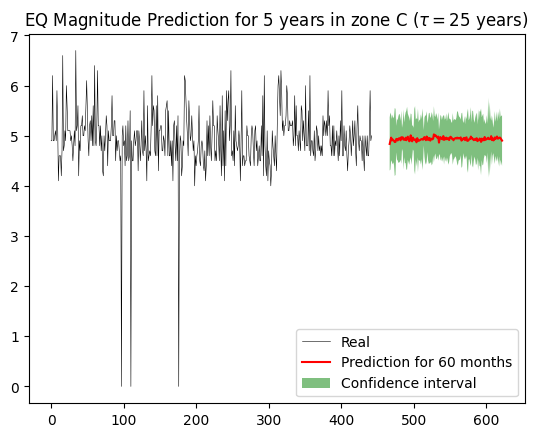

In [142]:
plt.title(r"EQ Magnitude Prediction for 5 years in zone C ($\tau = 25$ years)")

plt.plot(df_pred.index,
         df_pred.C,
         color='black',
         label="Real",
         linewidth=.4)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

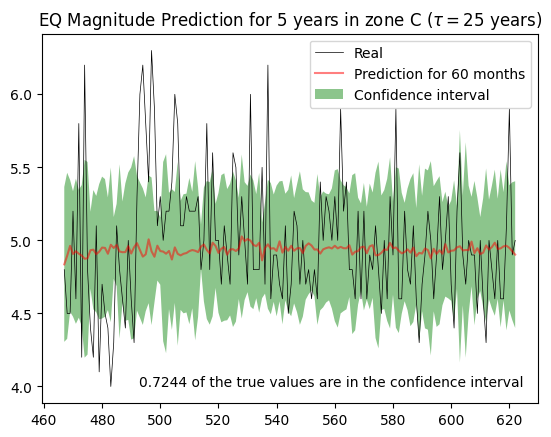

In [144]:
plt.rcParams.update(plt.rcParamsDefault)

plt.title(r"EQ Magnitude Prediction for 5 years in zone C ($\tau = 25$ years)")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.45)

plt.plot(idx_pred,
         df_pred.C[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} months".format(future_length),
         color="red",
         alpha=0.5)
plt.text(625, 4, f'{np.mean(total):.4f} of the true values are in the confidence interval', horizontalalignment='right')

plt.legend()